# Miami Heat Playoff Game Predictor
# (With multiple models)

This workbook contains code used to create 3 seperate models. The dataset in use is an excel document that I created with real playoff data from the 2020-2023 post-season.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import warnings; warnings.simplefilter("ignore")

Next I load the dataset and enumerate columns for visualization and feature selection. While there are many columns in the dataset, only a select few can be used prior to a game to make a prediction. These include: 
- The year of the game 
- The playoff game number (ex. game 1 of the series) 
- The location of the game (1 for home, 0 for away) 
- The number of rest days for each team
- The time of the game
- Each team's winning streak prior to the game
- The number of injuries for each team
- The significance of those injuries (biased feature)
- A calculated difference between moving averages for each teams ranking (Overall Ranking).

In [27]:
df = pd.read_csv("Miami_Heat_Playoff_Data_csv.csv")

game_num_encoded = pd.get_dummies(df["game_num"], prefix="game")

# Add the encoded columns to the original DataFrame
df = pd.concat([df, game_num_encoded], axis=1)


for i, col in enumerate(df.columns):
    print(f"{i}: {col}")
    
print(len(df))
display(df.head())

0: Year
1: game_num
2: heat_top_3_pts
3: opponent_top_3_pts
4: heat_pts
5: opponent_pts
6: Spread
7: heat_fg_perc
8: opponent_fg_pct
9: heat_3pt_perc
10: opponent_3pt_perc
11: heat_ft_perc
12: opponent_ft_perc
13: heat_off_reb
14: opponent_off_reb
15: heat_def_reb
16: opponent_def_reb
17: heat_assists
18: opponent_assists
19: heat_blocks
20: opponent_blocks
21: heat_steals
22: opponent_steals
23: heat_turnovers
24: opponent_turnovers
25: heat_pts_paint
26: opponent_pts_paint
27: heat_fouls
28: opponent_fouls
29: location
30: heat_rest_days
31: time
32: opponent_rest_days
33: heat_num_injuries
34: heat_signif_injuries
35: opponent_num_injuries
36: opponent_signif_injuries
37: heat_winning_streak
38: opponent_winning_streak
39: opponent
40: win_rank
41: pts_rank
42: reb_rank
43: ast_rank
44: plus_minus_rank
45: opponent_team_rank
46: opp_mov_avg
47: heat_win_rank
48: heat_pts_rank
49: heat_reb_rank
50: heat_ast_rank
51: heat_plus_minus_rank
52: heat_team_rank
53: heat_mov_avg
54: diff_mo

,Year,game_num,heat_top_3_pts,opponent_top_3_pts,heat_pts,opponent_pts,Spread,heat_fg_perc,opponent_fg_pct,heat_3pt_perc,...,heat_mov_avg,diff_mov,won,game_1,game_2,game_3,game_4,game_5,game_6,game_7
0,2023,1,75,70,130,117,13,59.5,49.5,60.0,...,82.400000,-14.450000,1,1,0,0,0,0,0,0
1,2023,2,59,71,122,138,-16,53.6,53.5,44.4,...,90.300000,-6.575000,0,0,1,0,0,0,0,0
2,2023,3,65,56,121,99,22,53.6,44.7,48.5,...,92.216667,-4.583333,1,0,0,1,0,0,0,0
3,2023,4,83,76,119,114,5,49.4,43.3,40.6,...,93.287500,-2.875000,1,0,0,0,1,0,0,0
4,2023,5,84,89,128,126,2,45.5,46.2,37.8,...,94.010000,-1.760000,1,0,0,0,0,1,0,0


The First model I train is a Logistic Regression Model and obtains an accuracy of approx. 0.62.

In [100]:

y = df.won
known_x = df[["location", "Year", "time", "heat_rest_days", "opponent_rest_days", "heat_num_injuries", "heat_signif_injuries", "opponent_num_injuries", "opponent_signif_injuries", "heat_winning_streak", "opponent_winning_streak", "diff_mov"]]
X_train, X_test, y_train, y_test = train_test_split(known_x, y, test_size = 0.35, random_state = 1)


lr1 = LogisticRegression(max_iter = 10000)
lr1.fit(X_train, y_train)
y_pred = lr1.predict(X_test)

print("Accuracy Score: ", lr1.score(X_test, y_test))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))

inputs = [[0, 2023, 8.5, 2, 2, 1, 1, 0, 0, 1, 7, 2.1]]
predicted_outcome = lr1.predict(inputs)
if predicted_outcome == 1:
    predicted_outcome = "win"
else:
    predicted_outcome = "lose"

print("game prediction:" + f"{predicted_outcome}")
print(lr1.predict_proba(inputs))


Accuracy Score:  0.625
Confusion Matrix: 
 [[ 5  5]
 [ 4 10]]
F1 Score:  0.689655172413793
Recall Score:  0.7142857142857143
Precision Score:  0.6666666666666666
game prediction:win
[[0.41514959 0.58485041]]


Now we can use Recursive Feature Elimination to find which features account for 95% of the variability of the target variable (Aims to improve accuracy of the model).

In [81]:
rfe = RFE(estimator = lr1)

rfe.fit(X_train, y_train)

num_features = sum(rfe.support_)
print(f"the achieved variability on the selected features: {rfe.score(X_test, y_test)}")
print(rfe.support_)

the achieved variability on the selected features: 0.5833333333333334
[ True False False  True False False False  True  True  True False  True]


## The features that will maximize accuracy:
1. Location
2. Number of rest days for Heat
3. Number of rest days for the Opponent
4. Opponent's number of injuries
5. The Miami Heat's winning streak prior to the game
6. The difference in overall ranking for each team (diff_mov)

In [72]:

y = df.won
known_x = df[["location", "heat_rest_days", "opponent_rest_days", "opponent_num_injuries", "heat_winning_streak", "diff_mov"]]
X_train, X_test, y_train, y_test = train_test_split(known_x, y, test_size = 0.35, random_state = 1)


lr1 = LogisticRegression(max_iter = 10000)
lr1.fit(X_train, y_train)
y_pred = lr1.predict(X_test)

print("Accuracy Score: ", lr1.score(X_test, y_test))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))

inputs = [[0, 2, 2, 1, 2, 2.1]]
predicted_outcome = lr1.predict(inputs)
if predicted_outcome == 1:
    predicted_outcome = "win"
else:
    predicted_outcome = "lose"

print("game prediction:" + f"{predicted_outcome}")
print(lr1.predict_proba(inputs))


Accuracy Score:  0.625
Confusion Matrix: 
 [[ 5  5]
 [ 4 10]]
F1 Score:  0.689655172413793
Recall Score:  0.7142857142857143
Precision Score:  0.6666666666666666
game prediction:win
[[0.49818698 0.50181302]]


The Next Model is a Decision Tree Classifier with an accuracy of approx 0.5. It is nice to have multiple models to base predictions on.

In [86]:
known_x_dt = df[["location", "Year", "time", "heat_rest_days", "opponent_rest_days", "heat_num_injuries", "heat_signif_injuries", "opponent_num_injuries", "opponent_signif_injuries", "heat_winning_streak", "opponent_winning_streak",  "diff_mov"]]
X_train, X_test, y_train, y_test = train_test_split(known_x_dt, y, test_size = 0.35, random_state = 42)


dtc_inputs = [[0,2023, 8.5, 3, 3, 1, 1, 0, 0, 1, 7, -3.1]]
dtc = DecisionTreeClassifier(max_depth = 4)
dtc.fit(X_train, y_train)
y_pred1 = dtc.predict(X_test)

predicted_outcome = dtc.predict(dtc_inputs)
predicted_outcome = dtc.predict(dtc_inputs)
if predicted_outcome == 1:
    predicted_outcome = "win"
else:
    predicted_outcome = "lose"

print("game prediction:" + f"{predicted_outcome}")




print("Accuracy Score: ", dtc.score(X_test, y_test))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred1))
print("F1 Score: ", f1_score(y_test, y_pred1))
print("Recall Score: ", recall_score(y_test, y_pred1))
print("Precision Score: ", precision_score(y_test, y_pred1))

game prediction:lose
Accuracy Score:  0.5
Confusion Matrix: 
 [[8 5]
 [7 4]]
F1 Score:  0.39999999999999997
Recall Score:  0.36363636363636365
Precision Score:  0.4444444444444444


We can once again use Recursive Feature Elimination to choose the best features.

In [85]:
rfe = RFE(estimator = dtc)

rfe.fit(X_train, y_train)

num_features = sum(rfe.support_)
print(rfe.support_)
print(num_features)

[False False  True False False  True  True False False  True  True  True]
6



## Most important Features to decision tree:

1. Time of the game
2. Heat number of injuries before the game
3. Heat significance of injuries before the game
4. Heat's winning streak
5. The Opponent's winning streak
6. The difference in overall ranking (diff_mov)

In [90]:
known_x_dt = df[["time", "heat_num_injuries", "heat_signif_injuries", "heat_winning_streak", "opponent_winning_streak",  "diff_mov"]]
X_train, X_test, y_train, y_test = train_test_split(known_x_dt, y, test_size = 0.3, random_state = 42)


dtc_inputs = [[8.5, 1, 1, 2, 1, -3.1]]
dtc = DecisionTreeClassifier(max_depth = 3)
dtc.fit(X_train, y_train)
y_pred1 = dtc.predict(X_test)

predicted_outcome = dtc.predict(dtc_inputs)
predicted_outcome = dtc.predict(dtc_inputs)
if predicted_outcome == 1:
    predicted_outcome = "win"
else:
    predicted_outcome = "lose"

print("game prediction:" + f"{predicted_outcome}")




print("Accuracy Score: ", dtc.score(X_test, y_test))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred1))
print("F1 Score: ", f1_score(y_test, y_pred1))
print("Recall Score: ", recall_score(y_test, y_pred1))
print("Precision Score: ", precision_score(y_test, y_pred1))

game prediction:lose
Accuracy Score:  0.47619047619047616
Confusion Matrix: 
 [[ 1 10]
 [ 1  9]]
F1 Score:  0.6206896551724138
Recall Score:  0.9
Precision Score:  0.47368421052631576


- Due to the low accuracy score, the Decision Tree Classifier Model should not be used to make predictions

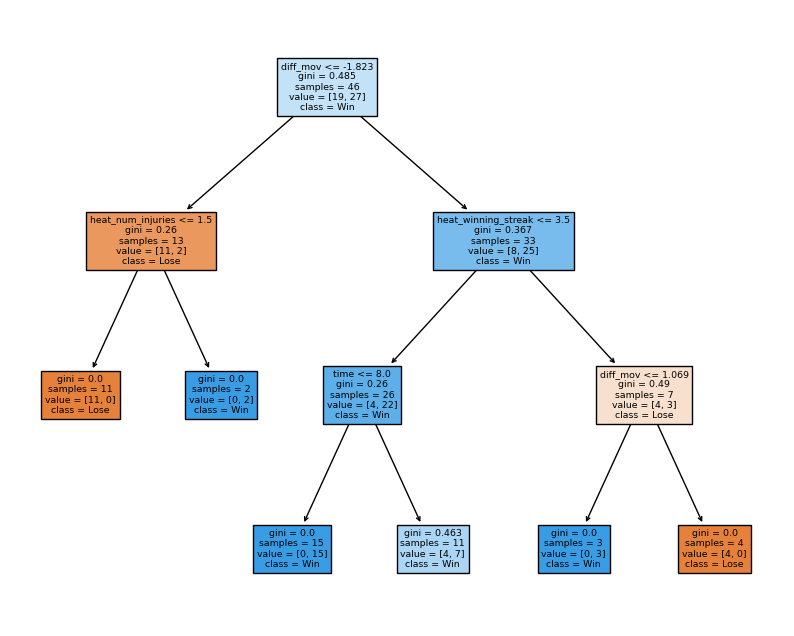

In [92]:
plt.figure(figsize=(10, 8))
plot_tree(dtc, filled=True, feature_names=X_train.columns, class_names=["Lose", "Win"])
plt.show()

We can however, test a random forest classifier to attempt to improve the accuracy of the decision tree model

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



# Create the random forest classifier with the decision tree classifier as the base estimator
rfc = RandomForestClassifier(n_estimators=5, max_depth = 3, random_state = 10)

# Train the random forest classifier
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred2 = rfc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)


predicted_outcome = rfc.predict(dtc_inputs)
predicted_outcome = rfc.predict(dtc_inputs)
if predicted_outcome == 1:
    predicted_outcome = "win"
else:
    predicted_outcome = "lose"

print("game prediction:" + f"{predicted_outcome}")
y_pred2 = rfc.predict(X_test)


print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred2))
print("F1 Score: ", f1_score(y_test, y_pred2))
print("Recall Score: ", recall_score(y_test, y_pred2))
print("Precision Score: ", precision_score(y_test, y_pred2))

Accuracy: 0.6190476190476191
game prediction:lose
Confusion Matrix: 
 [[6 5]
 [3 7]]
F1 Score:  0.6363636363636365
Recall Score:  0.7
Precision Score:  0.5833333333333334


- Granted that predicting the outcomes of professional sports games is a very challenging task, the models that can be used for this dataset are:
1. Logistic Regression Model (accuracy score: 0.625)
2. Random Forest Classifier (accuracy score: 0.619)